# Privacy-Preserving Detection of COVID-19 in X-Ray Images (DP-SGD)

###### Notebook settings

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Prerequisites

###### Install packages

In [2]:
!pip install tensorflow-privacy

     |████████████████████████████████| 215kB 15.8MB/s 


##### Import libraries

In [3]:
import os, random
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

from tensorflow_privacy.privacy.analysis.rdp_accountant import compute_rdp
from tensorflow_privacy.privacy.analysis.rdp_accountant import get_privacy_spent
from tensorflow_privacy.privacy.analysis.compute_noise_from_budget_lib import compute_noise
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras_vectorized import VectorizedDPKerasSGDOptimizer

import keras
from keras.models import Sequential
from keras.losses import BinaryCrossentropy
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.experimental.preprocessing import Resizing, Rescaling, RandomFlip, RandomRotation, RandomTranslation, RandomZoom
from keras.layers import Layer, InputLayer, Conv2D, Activation, Add, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, ZeroPadding2D, Flatten

##### Download dataset

###### *COVID-19 Radiography Database*  
[Kaggle](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database)
[Paper 1](https://ieeexplore.ieee.org/document/9144185)
[Paper 2](https://doi.org/10.1016/j.compbiomed.2021.104319)

In [4]:
if not os.path.exists('COVID-19_Radiography_Dataset'):
    !gdown https://drive.google.com/uc?id=1ZMgUQkwNqvMrZ8QaQmSbiDqXOWAewwou
    !unzip -q COVID-19_Radiography_Database.zip
    !rm COVID-19_Radiography_Database.zip

Downloading...
From: https://drive.google.com/uc?id=1ZMgUQkwNqvMrZ8QaQmSbiDqXOWAewwou
To: /content/COVID-19_Radiography_Database.zip
780MB [00:14, 53.2MB/s]


##### Define constants

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Data parameters
SPLIT = 0.15
IMBALANCE_RATIO = 1.5

# Model parameters
BATCH_SIZE = 16 # TODO test with 32
IMG_SIZE = [256, 256] # dataset image size is 299x299
EPOCHS = 20

# DP-SGD parameters
NOISE_MULTIPLIER = 0.76
L2_NORM_CLIP = 1.0
MICROBATCHES = BATCH_SIZE

# Set fixed random seed
seed = 42
np.random.seed(seed)
random.seed(seed)
random_state = 42

## Data


### Create dataset

In [6]:
savepath = 'data'

## dataset from https://www.kaggle.com/tawsifurrahman/covid19-radiography-database

# path to normal 
normal_imgpath = 'COVID-19_Radiography_Dataset/Normal'
normal_csvpath = 'COVID-19_Radiography_Dataset/Normal.metadata.xlsx'

# path to covid-19 
covid_imgpath = 'COVID-19_Radiography_Dataset/COVID'
covid_csvpath = 'COVID-19_Radiography_Dataset/COVID.metadata.xlsx'

# path to opacity 
opacity_imgpath = 'COVID-19_Radiography_Dataset/Lung_Opacity'
opacity_csvpath = 'COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx'

# path to pneumonia 
pneumonia_imgpath = 'COVID-19_Radiography_Dataset/Viral Pneumonia'
pneumonia_csvpath = 'COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx'

In [7]:
# stats
normal_cnt = len([name for name in os.listdir(normal_imgpath) if os.path.isfile(os.path.join(normal_imgpath, name))])
covid_cnt = len([name for name in os.listdir(covid_imgpath) if os.path.isfile(os.path.join(covid_imgpath, name))])
pneumonia_cnt = len([name for name in os.listdir(opacity_imgpath) if os.path.isfile(os.path.join(opacity_imgpath, name))]) + len([name for name in os.listdir(pneumonia_imgpath) if os.path.isfile(os.path.join(pneumonia_imgpath, name))])

class_count = {'normal': normal_cnt, 'COVID-19': covid_cnt, 'pneumonia': pneumonia_cnt}
print('Class count: ', class_count)
print('Total images: ', normal_cnt + covid_cnt + pneumonia_cnt)

Class count:  {'normal': 10192, 'COVID-19': 3616, 'pneumonia': 7357}
Total images:  21165


### Load dataset

###### Retrieve filenames (paths) and labels

In [8]:
def get_data(paths, label_encoding):
    normal_imgpath, covid_imgpath = paths
    filenames = []
    y_labels = []

    # COVID-19
    covid_images = [covid_imgpath + '/' + name for name in os.listdir(covid_imgpath) if os.path.isfile(os.path.join(covid_imgpath, name))]
    random.shuffle(covid_images)
    covid_images = covid_images[:int(len(covid_images))]
    filenames.extend(covid_images)
    y_labels.extend([label_encoding.index('COVID-19') for img in covid_images])

    # normal
    normal_images = [normal_imgpath + '/' + name for name in os.listdir(normal_imgpath) if os.path.isfile(os.path.join(normal_imgpath, name))]
    random.shuffle(normal_images)
    normal_images = normal_images[:int(IMBALANCE_RATIO*len(covid_images))]
    filenames.extend(normal_images)
    y_labels.extend([label_encoding.index('normal') for img in normal_images])

    return np.array(filenames), np.array(y_labels)

In [9]:
datapaths = ['COVID-19_Radiography_Dataset/Normal', 'COVID-19_Radiography_Dataset/COVID']
label_encoding = ['normal', 'COVID-19'] # normal = 0, COVID-19 = 1

files, labels = get_data(datapaths, label_encoding)

###### Create train-test split

In [10]:
# create train-test split
x_train, x_test, y_train, y_test = train_test_split(files, labels, test_size=SPLIT, random_state=random_state)

In [11]:
def get_distribution(y):
    return {'normal': np.count_nonzero(y == 0),
            'COVID-19': np.count_nonzero(y == 1)}

In [12]:
TRAIN_IMG_COUNT = len(y_train)
TEST_IMG_COUNT = len(y_test)
print(
    'Train: ' + str(TRAIN_IMG_COUNT) + ',',
    'Test: ' + str(TEST_IMG_COUNT),
)

Train: 7684, Test: 1356


In [13]:
TRAIN_DISTRIBUTION = get_distribution(y_train)
TEST_DISTRIBUTION = get_distribution(y_test)
print('train set: ', TRAIN_DISTRIBUTION)
print('test set:  ', TEST_DISTRIBUTION)

train set:  {'normal': 4607, 'COVID-19': 3077}
test set:   {'normal': 817, 'COVID-19': 539}


###### Create tensors

In [14]:
# build tensorflow dataset
train_files = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_files = tf.data.Dataset.from_tensor_slices((x_test, y_test))

###### Image retrieval

In [15]:
def get_img(x, y):
    path = x
    label = y
    # load the raw data from the file as a string
    img = tf.io.read_file(path)
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_image(img, channels=3, expand_animations = False)
    return img, label

In [16]:
train_ds = train_files.map(get_img, num_parallel_calls=AUTOTUNE)
test_ds = test_files.map(get_img, num_parallel_calls=AUTOTUNE)

### Prepare for training

###### Define preprocessing and data augmentation

In [17]:
preprocessing = tf.keras.Sequential([
  Resizing(IMG_SIZE[0], IMG_SIZE[1]),
  Rescaling(scale=1./255)
])

In [18]:
# implemented as keras layers below but kept for overview
datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range=(0.85, 1.15),
        brightness_range=(0.9, 1.1),
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True,
        fill_mode='constant',
        cval=0.,)

In [19]:
class RandomBrightness(Layer):
  def __init__(self, factor=0.1, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return tf.image.random_brightness(x, max_delta=self.factor)

In [20]:
data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.1, fill_mode='constant'),
  RandomTranslation(0.1, 0.1, fill_mode='constant'),
  RandomZoom(0.15, fill_mode='constant'),
  RandomBrightness(0.1),
])

###### Prepare datasets for use

In [21]:
def prepare_dataset(ds, cache=True, pre=False, shuffle=False, repeat=False, batch=False, augment=False, shuffle_buffer_size=1000):
    # give string to cache preprocessing for datasets outside of memory
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    # Resize and rescale images
    if pre:
        ds = ds.map(lambda x, y: (preprocessing(x), y),
                    num_parallel_calls=AUTOTUNE)
    # shuffle dataset
    if shuffle:
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # repeat set forever or once
    if repeat:
        ds = ds.repeat()
    else:
        ds = ds.repeat(1)
    # batch dataset
    if batch:
        ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    # use data augmentation
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=AUTOTUNE)

    return ds

In [22]:
# batch datasets
train_batched = prepare_dataset(train_ds,
                                pre=True,
                                shuffle=True,
                                repeat=True,
                                batch=True,
                                augment=True,
                                cache='./data.tfcache')
test_batched = prepare_dataset(test_ds,
                               pre=True,
                               shuffle=False,
                               repeat=False,
                               batch=True,
                               augment=False)

In [23]:
# seperate train labels and images for attacks
train_unbatched= prepare_dataset(train_ds,
                                 pre=True,
                                 shuffle=True,
                                 repeat=False,
                                 batch=False,
                                 augment=False,
                                 cache=False)
x_train_attack = prepare_dataset(train_unbatched,
                                 pre=False,
                                 shuffle=False,
                                 repeat=False,
                                 batch=True, # TODO batching needed?
                                 augment=False)
y_train_attack = []
for x, y in tf.data.Dataset.as_numpy_iterator(train_unbatched):
    y_train_attack.append(y)

# seperate test labels and images for attacks
test_unbatched = prepare_dataset(test_ds,
                                 pre=True,
                                 shuffle=False,
                                 repeat=False,
                                 batch=False,
                                 augment=False,
                                 cache=False)
x_test_attack = prepare_dataset(test_unbatched,
                                pre=False,
                                shuffle=False,
                                repeat=False,
                                batch=True, # TODO batching needed?
                                augment=False)
y_test_attack = []
for x, y in tf.data.Dataset.as_numpy_iterator(test_unbatched):
    y_test_attack.append(y)

### Visualization

###### Distribution of labels in the sets

In [24]:
def plot_distributions(distributions):
    sns.set_style('darkgrid')
    n_plots = len(distributions)
    fig, ax = plt.subplots(1,n_plots, figsize=(15,5))
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    for i, x in enumerate(distributions.items()):
        name = x[0]
        dis = x[1]
        keys = list(dis.keys())
        values = list(dis.values())
        sns.barplot(x=keys, y=values, ax=ax[i]).set_title(name)
    fig.show()

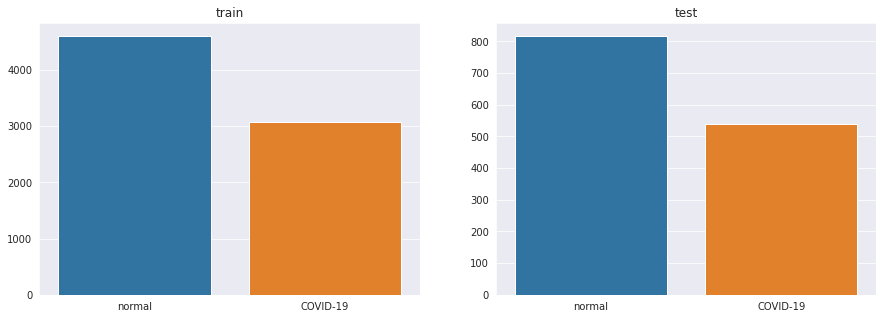

In [25]:
plot_distributions({'train': TRAIN_DISTRIBUTION, 'test': TEST_DISTRIBUTION})

###### Images from a training batch

In [26]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    img_num = 9 if BATCH_SIZE > 9 else BATCH_SIZE
    for n in range(img_num):
        ax = plt.subplot(np.log(img_num) / np.log(2), np.log(img_num) / np.log(2), n+1)
        plt.imshow(image_batch[n])
        if label_batch[n] == 0:
            plt.title("NORMAL")
        elif label_batch[n] == 1:
            plt.title("COVID-19")
        plt.axis("off")

In [27]:
image_batch, label_batch = next(iter(train_batched))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


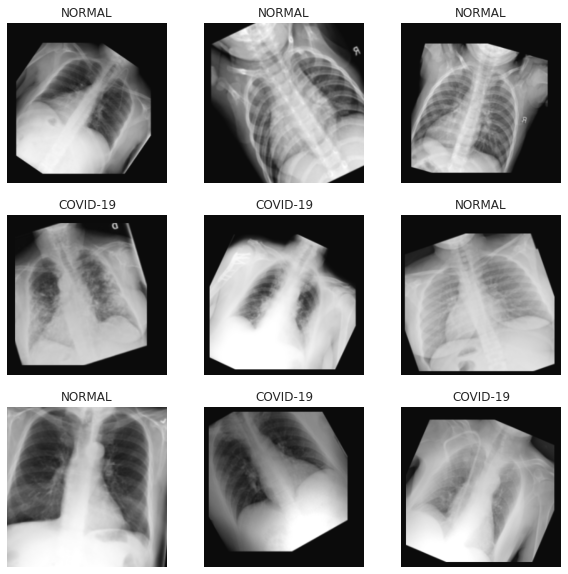

In [28]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Tuning

### Data Imbalance Correction

Define class weights

In [29]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weight_dict = dict(enumerate(class_weights))

weight_iter = iter(class_weight_dict.values())

print('Weight for normal: \t{:.2f}'.format(next(weight_iter)))
print('Weight for COVID-19: \t{:.2f}'.format(next(weight_iter)))

Weight for normal: 	0.83
Weight for COVID-19: 	1.25


### Learning rate decay

In [30]:
learning_rate_decay = ReduceLROnPlateau(monitor='loss', patience=2, factor=0.1, min_lr=1e-6)

## DP-Net - CNN Archecture for DP-SGD
Based on [Paper 1](https://arxiv.org/abs/2007.14191)
\([Paper 2](https://openreview.net/forum?id=rJg851rYwH)\)
[Paper BN](https://arxiv.org/pdf/2006.10919.pdf)

### Model definition

In [31]:
def dpnet_builder():
    # create DP-Net
    dpnet = Sequential([
        InputLayer(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        Conv2D(filters=16, kernel_size=(8,8), strides=2, padding='valid', activation='tanh'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(filters=32, kernel_size=(4,4), strides=2, padding='valid', activation='tanh'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(units=32, activation='tanh'),
        BatchNormalization(),
        Dense(units=1, activation='sigmoid'),
    ])
    return dpnet

In [32]:
dpnet = dpnet_builder()

METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

dpnet.compile(  
    optimizer=VectorizedDPKerasSGDOptimizer(
        l2_norm_clip=L2_NORM_CLIP,
        noise_multiplier=NOISE_MULTIPLIER,
        num_microbatches=MICROBATCHES,
        learning_rate=1e-1
    ),
    loss=BinaryCrossentropy(
        from_logits=True,
        reduction=tf.compat.v1.losses.Reduction.NONE
        # reduction is set to NONE to get loss in a vector form
    ),
    metrics=METRICS
)

In [33]:
dpnet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 125, 125, 16)      3088      
_________________________________________________________________
batch_normalization (BatchNo (None, 125, 125, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        8224      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7200)              0

### Training

In [34]:
history_dpnet = dpnet.fit(
    train_batched,
    steps_per_epoch=TRAIN_IMG_COUNT//BATCH_SIZE,
    epochs=EPOCHS,
    class_weight=class_weight_dict,
    callbacks=[learning_rate_decay],
)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4982: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


480/480 [==============================] - 144s 222ms/step - loss: 0.9015 - accuracy: 0.5845 - precision: 0.4926 - recall: 0.5711
Epoch 2/20
480/480 [==============================] - 97s 201ms/step - loss: 1.0494 - accuracy: 0.6274 - precision: 0.5438 - recall: 0.5314
Epoch 3/20
480/480 [==============================] - 96s 200ms/step - loss: 1.1646 - accuracy: 0.6413 - precision: 0.5662 - recall: 0.4796
Epoch 4/20
480/480 [==============================] - 96s 201ms/step - loss: 1.1081 - accuracy: 0.6481 - precision: 0.5851 - recall: 0.4524
Epoch 5/20
480/480 [==============================] - 96s 201ms/step - loss: 1.1057 - accuracy: 0.6431 - precision: 0.5685 - recall: 0.4370
Epoch 6/20
480/480 [==============================] - 96s 200ms/step - loss: 1.1006 - accuracy: 0.6460 - precision: 0.5860 - recall: 0.4307
Epoch 7/20
480/480 [==============================] - 96s 200ms/step - loss: 1.1574 - accuracy: 0.6318 - precision: 0.5694 - recall: 0.4203
Epoch 8/20
480/480 [==========

### Evaluation

###### Visualize performance

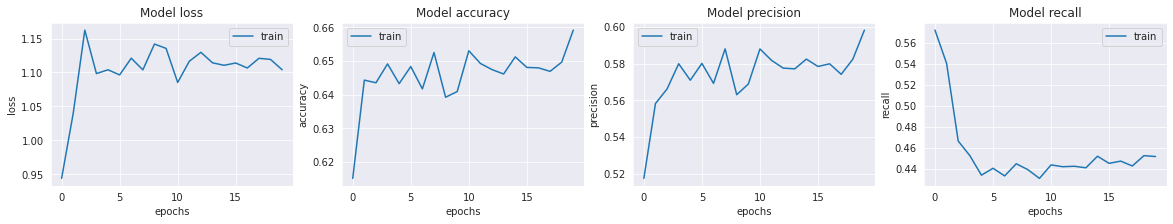

In [35]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    ax[i].plot(history_dpnet.history[met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train'])

###### Predict on test set

In [36]:
loss, acc, prec, rec = dpnet.evaluate(test_batched)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , acc*100 , "%")
print("Precision of the model is - " , prec)
print("Recall of the model is - " , rec)

/usr/local/lib/python3.7/dist-packages/keras/backend.py:4982: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


85/85 [==============================] - 4s 38ms/step - loss: 0.9710 - accuracy: 0.6932 - precision: 0.7158 - recall: 0.3785
Loss of the model is -  0.9710173010826111
Accuracy of the model is -  69.32153105735779 %
Precision of the model is -  0.7157894968986511
Recall of the model is -  0.37847867608070374


## Privacy

### Compute epsilon

In [37]:
# delta rule of thumb: set to less than the inverse of the training data size
DELTA = 1e-4

In [38]:
# computes epsilon for given hyperparameters
def compute_epsilon(n, batch_size, noise_multiplier, epochs, delta):
    if noise_multiplier == 0.0:
        return float('inf')
    sampling_probability = batch_size / n
    steps = int(np.ceil(epochs * n / batch_size))
    orders = [1 + x / 10. for x in range(1, 100)] + list(range(12, 64))
    rdp = compute_rdp(
        q = sampling_probability,
        noise_multiplier = noise_multiplier,
        steps = steps,
        orders = orders)
    return get_privacy_spent(orders, rdp, target_delta=delta)[0]

In [39]:
eps = compute_epsilon(
    TRAIN_IMG_COUNT,
    BATCH_SIZE,
    NOISE_MULTIPLIER,
    EPOCHS,
    DELTA)
print('Delta = %.e, Epsilon = %.3f'%(DELTA, eps))

Delta = 1e-04, Epsilon = 2.001


In [40]:
# get needed noise for target epsilon
min_noise = 1e-5
target_epsilon = 2.0
compute_noise(
    TRAIN_IMG_COUNT,
    BATCH_SIZE,
    target_epsilon,
    EPOCHS,
    DELTA,
    min_noise
)

DP-SGD with sampling rate = 0.208% and noise_multiplier = 0.7601405892956258 iterated over 9605 steps satisfies differential privacy with eps = 2 and delta = 0.0001.


0.7601405892956258

### Attacks

###### Membership Inference Attack

In [41]:
import tensorflow_privacy.privacy.membership_inference_attack.plotting as plotting
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackType
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.membership_inference_attack import membership_inference_attack as mia

In [42]:
print('Predict on train...')
probs_train = dpnet.predict(x_train_attack)
print('Predict on test...')
probs_test = dpnet.predict(x_test_attack)

# only label as output instead of prob
#probs_train = np.round(logits_train)
#probs_test = np.round(logits_test)


print('Compute losses...')
bc = tf.keras.backend.binary_crossentropy
constant = tf.keras.backend.constant

loss_train = np.array([x[0] for x in bc(constant([[y] for y in y_train_attack]), constant(probs_train), from_logits=False).numpy()])
loss_test = np.array([x[0] for x in bc(constant([[y] for y in y_test_attack]), constant(probs_test), from_logits=False).numpy()])

train_labels = np.array(y_train_attack)
test_labels = np.array(y_test_attack)

Predict on train...
Predict on test...
Compute losses...


Suspiciously low AUC detected: %.2f. There might be a bug in the classifier
Suspiciously low AUC detected: %.2f. There might be a bug in the classifier
Suspiciously low AUC detected: %.2f. There might be a bug in the classifier
Suspiciously low AUC detected: %.2f. There might be a bug in the classifier
Suspiciously low AUC detected: %.2f. There might be a bug in the classifier
Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 539 training and 539 test examples) achieved an AUC of 0.62 on slice CLASS=1
  LOGISTIC_REGRESSION (with 539 training and 539 test examples) achieved an advantage of 0.21 on slice CLASS=1

Best-performing attacks over slice: "Entire dataset"
  LOGISTIC_REGRESSION (with 1356 training and 1356 test examples) achieved an AUC of 0.60
  LOGISTIC_REGRESSION (with 1356 training and 1356 test examples) achieved an advantage of 0.20

Best-performing attacks over slice: "CLASS=0"
  LOGISTIC_REGRESSION (with 817 training and 817 test examples) achieved an A

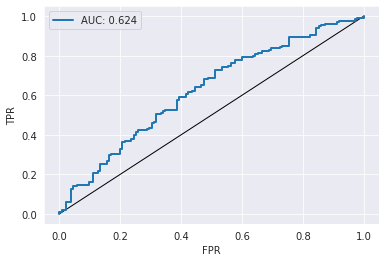

In [43]:
attack_input = AttackInputData(
  logits_train = probs_train,
  logits_test = probs_test,
  loss_train = loss_train,
  loss_test = loss_test,
  labels_train = train_labels,
  labels_test = test_labels
)

slicing_spec = SlicingSpec(
    entire_dataset = True,
    by_class = True,
    by_percentiles = False,
    by_classification_correctness = True)

attack_types = [
    AttackType.THRESHOLD_ATTACK,
    AttackType.LOGISTIC_REGRESSION
] 

# Run several attacks for different data slices
attacks_result = mia.run_attacks(attack_input=attack_input,
                                 slicing_spec=slicing_spec,
                                 attack_types=attack_types)

# Plot the ROC curve of the best classifier
plotting.plot_roc_curve(attacks_result.get_result_with_max_auc().roc_curve)

# Print a user-friendly summary of the attacks
print(attacks_result.summary(by_slices=True))